# K2 Lightcurve Fitting with CARMA Models

In [1]:
push!(LOAD_PATH, "/Users/farr/Documents/Research/GaussianNoiseModeling/PopeFilters/code")

3-element Array{ByteString,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.4"     
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.4"           
 "/Users/farr/Documents/Research/GaussianNoiseModeling/PopeFilters/code"

In [2]:
using Ensemble
using Kalman
using PyCall
using PyPlot

In [3]:
@pyimport seaborn
seaborn.set_style("ticks")

## Data

In [4]:
name0 = "EPIC 211000411"
name9 = "EPIC 211098454"

"EPIC 211098454"

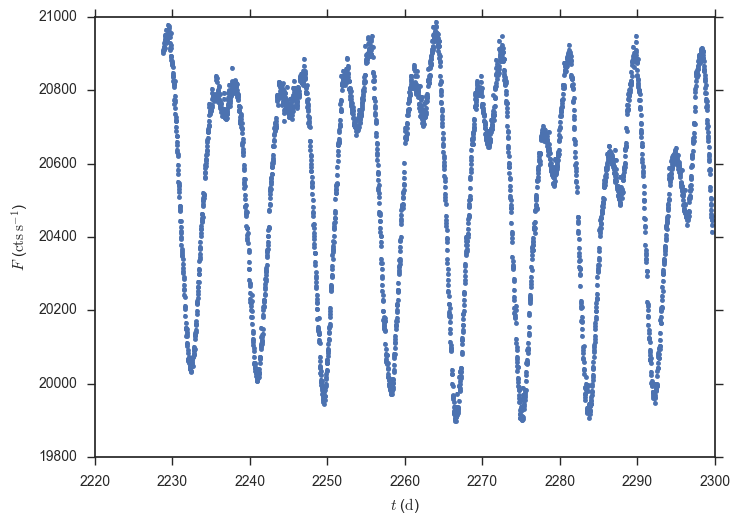

PyObject <matplotlib.text.Text object at 0x321ec6d10>

In [5]:
lc0 = readdlm("epic211000411.txt")
errorbar(lc0[:,1], lc0[:,2], lc0[:,3], fmt=".")
xlabel(L"$t$ ($\mathrm{d}$)")
ylabel(L"$F$ ($\mathrm{cts} \, \mathrm{s}^{-1}$)")

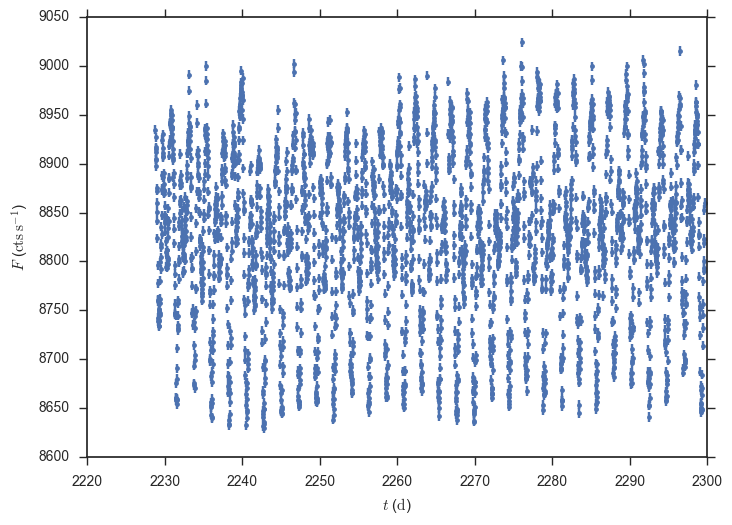

PyObject <matplotlib.text.Text object at 0x32407af50>

In [6]:
lc9 = readdlm("epic211098454.txt")
errorbar(lc9[:,1], lc9[:,2], lc9[:,3], fmt=".")
xlabel(L"$t$ ($\mathrm{d}$)")
ylabel(L"$F$ ($\mathrm{cts} \, \mathrm{s}^{-1}$)")

## Simulations of $(5,4)$ CARMA Models

In [7]:
ns0 = open(deserialize, "epic211000411-CARMA/state-5-4.dat", "r")
ps0 = EnsembleNest.postsample(ns0)
nps0 = size(ps0, 2)
post0 = Kalman.CARMAKalmanPosterior(lc0[:,1], lc0[:,2], lc0[:,3], 5, 4)
size(ps0)

(12,7111)

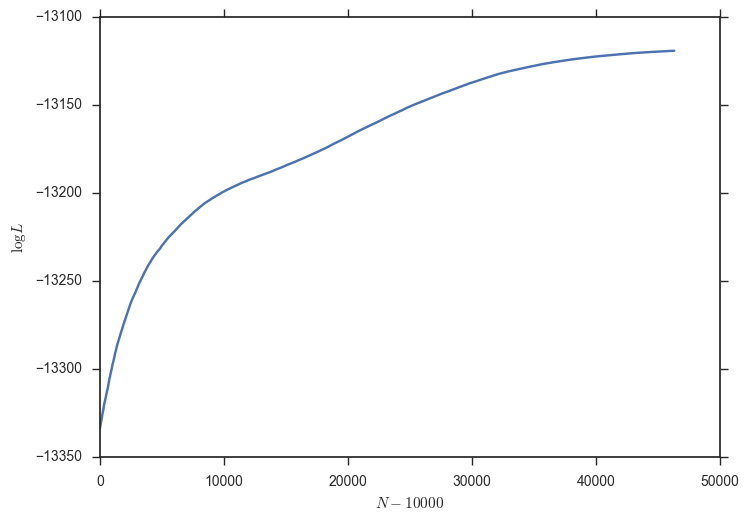

PyObject <matplotlib.text.Text object at 0x32406eb10>

In [8]:
plot(ns0.deadlogls[10000:end])
xlabel(L"$N-10000$")
ylabel(L"$\log L$")

In [9]:
ns9 = open(deserialize, "epic211098454-CARMA//state-5-4.dat", "r")
ps9 = EnsembleNest.postsample(ns9)
nps9 = size(ps9, 2)
post9 = Kalman.CARMAKalmanPosterior(lc9[:,1], lc9[:,2], lc9[:,3], 5, 4)
size(ps9)

(12,6382)

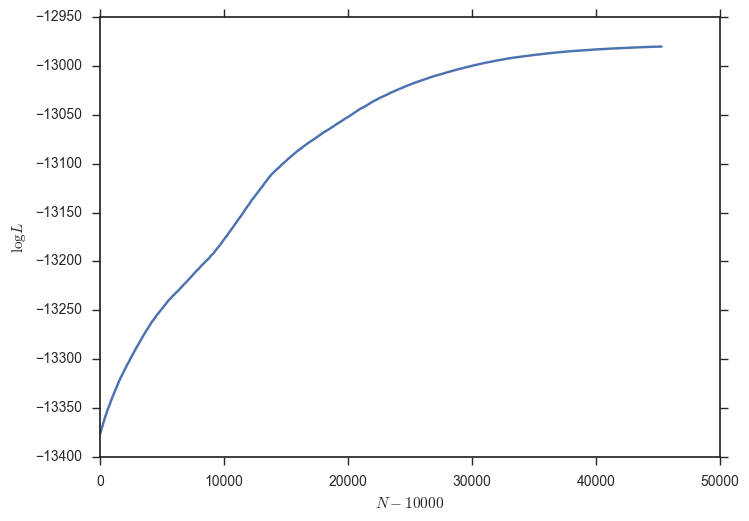

PyObject <matplotlib.text.Text object at 0x324682490>

In [10]:
plot(ns9.deadlogls[10000:end])
xlabel(L"$N-10000$")
ylabel(L"$\log L$")

## PSDs

In [11]:
fs0 = Kalman.psdfreq(post0)
fs9 = Kalman.psdfreq(post9)
psds0 = Kalman.psd(post0, ps0[:, rand(1:nps0, 1000)], fs0)
psds9 = Kalman.psd(post9, ps9[:, rand(1:nps9, 1000)], fs9)

1734x1000 Array{Float64,2}:
 276.006     282.371     242.472     …  210.631     255.464     224.877   
 275.977     282.5       242.488        210.757     255.508     224.959   
 275.932     282.72      242.519        210.971     255.584     225.099   
 275.877     283.039     242.568        211.278     255.7       225.302   
 275.821     283.467     242.642        211.686     255.862     225.576   
 275.774     284.019     242.748     …  212.205     256.082     225.93    
 275.751     284.713     242.899        212.849     256.373     226.377   
 275.77      285.575     243.106        213.634     256.752     226.933   
 275.851     286.632     243.387        214.582     257.242     227.618   
 276.021     287.922     243.763        215.719     257.87      228.457   
 276.313     289.49      244.259     …  217.078     258.666     229.478   
 276.766     291.392     244.906        218.699     259.674     230.722   
 277.428     293.698     245.743        220.633     260.942     232.233 

Plot the PSDs:

In [12]:
function plot_psd(fs, psd)
    nf = size(fs, 1)
    ns = size(psd, 2)

    m = zeros(nf)
    h = zeros(nf)
    l = zeros(nf)
    
    for i in 1:nf
        m[i] = median(vec(psd[i,:]))
        h[i] = quantile(vec(psd[i,:]), 0.84)
        l[i] = quantile(vec(psd[i,:]), 0.16)
    end
    
    plot(fs, m)
    fill_between(fs, h, l, alpha=0.5)
    xscale("log")
    yscale("log")
    xlabel(L"$f$ ($\mathrm{d}^{-1}$)")
    ylabel(L"$P(f)$ ($\mathrm{cts}^2 \, \mathrm{s}^{-2} \, \mathrm{d}$)")
end

plot_psd (generic function with 1 method)

The PSD for EPIC 211000411, which has the evolving signal and correspondingly wide modes.

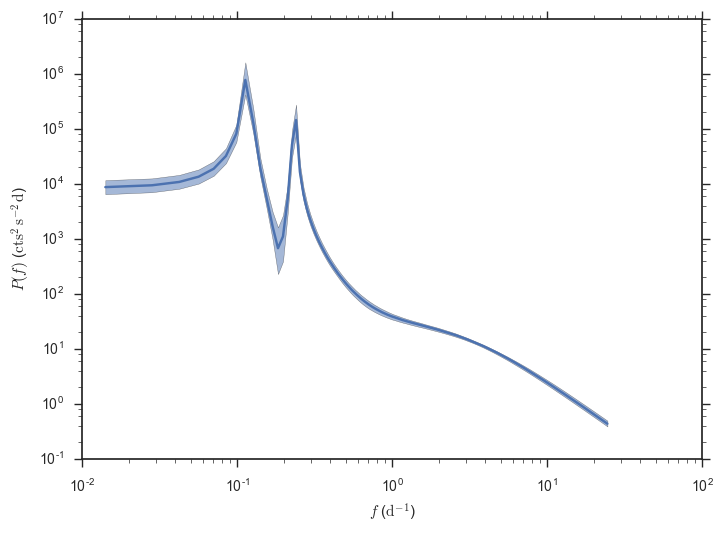

PyObject <matplotlib.text.Text object at 0x32483db10>

In [13]:
plot_psd(fs0, psds0)

The PSD for EPIC 211098454, with very sharp modes.

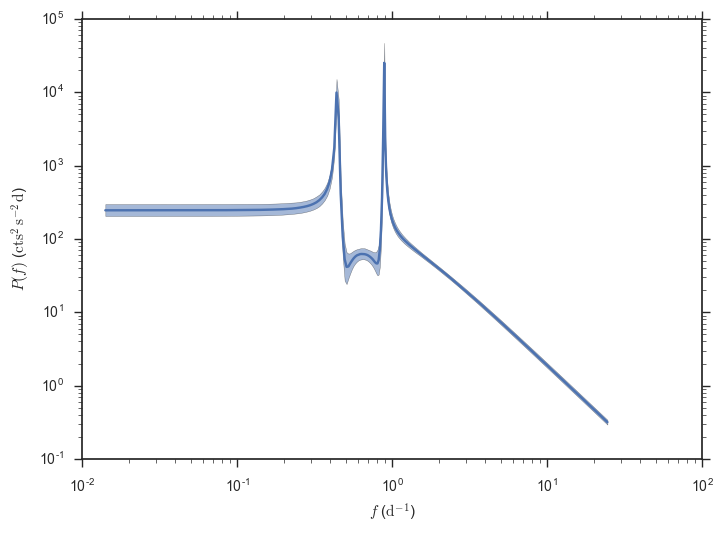

PyObject <matplotlib.text.Text object at 0x325db39d0>

In [14]:
plot_psd(fs9, psds9)

## Minimum Frequency (Longest Period) Mode

We want to plot the longest period in the data (lowest frequency) for the two stars, the amplitude ratio of the two peaks that appear, and the period or frequency ratio.  For some reason, the seaborn KDE is giving us trouble here, so all the plots are histogram-only.

In [15]:
freqs0 = Kalman.frequencies(post0, ps0)
freqs9 = Kalman.frequencies(post9, ps9)
fmin0 = zeros(size(freqs0,2))
fmax0 = zeros(size(freqs0,2))
fmin9 = zeros(size(freqs9,2))
fmax9 = zeros(size(freqs9,2))
for i in 1:size(fmin0,1)
    fs = freqs0[:,i]
    fs = fs[fs .> 0]
    fmin0[i] = minimum(fs)
    fmax0[i] = maximum(fs)
end
for i in 1:size(fmin9,1)
    fs = freqs9[:,i]
    fs = fs[fs .> 0]
    fmin9[i] = minimum(fs)
    fmax9[i] = maximum(fs)
end

In [16]:
Pmax0 = 1.0./fmin0
Pmin0 = 1.0./fmax0
Pmax9 = 1.0./fmin9
Pmin9 = 1.0./fmax9

6382-element Array{Float64,1}:
 1.12739
 1.12973
 1.13265
 1.12983
 1.12937
 1.12742
 1.12893
 1.12701
 1.13382
 1.12984
 1.12972
 1.12856
 1.12984
 ⋮      
 1.12886
 1.12882
 1.12881
 1.12923
 1.12964
 1.12882
 1.13036
 1.1284 
 1.12938
 1.12889
 1.12799
 1.12907

Period of EPIC 211000411 = 8.579484385032554 +/- 0.1644751989784144 d


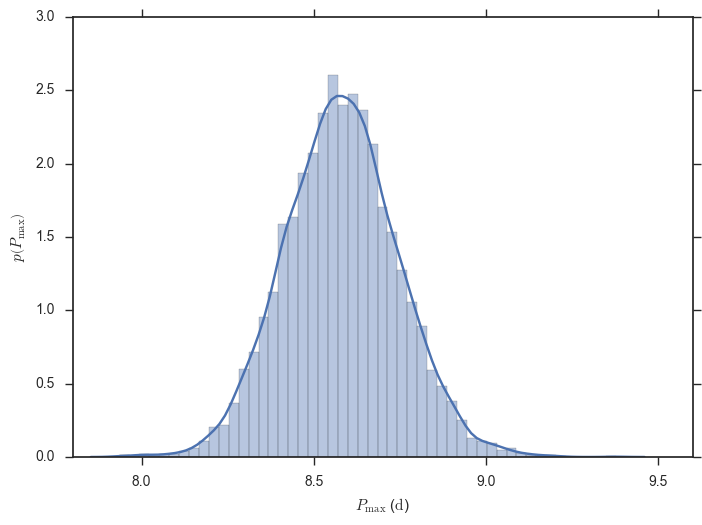

In [19]:
seaborn.distplot(Pmax0)
xlabel(L"$P_\mathrm{max}$ ($\mathrm{d}$)")
ylabel(L"$p\left( P_\mathrm{max}\right)$")
println("Period of $name0 = $(mean(Pmax0)) +/- $(std(Pmax0)) d")

Period of EPIC 211098454 = 2.2533146308096854 +/- 0.0075036761716582015 d


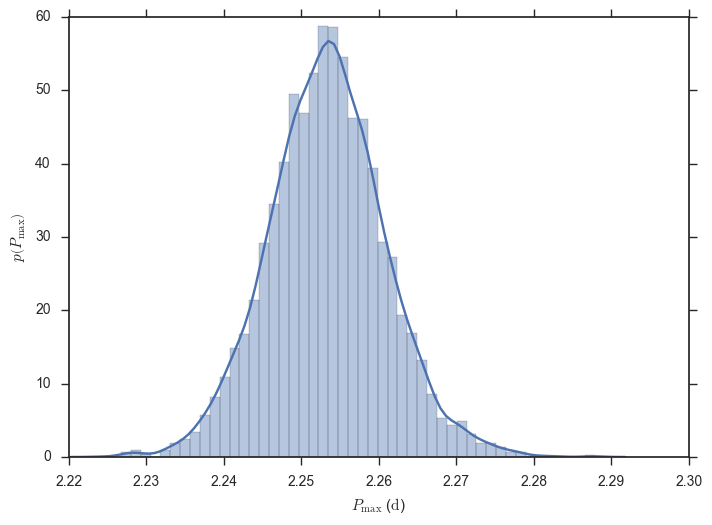

In [20]:
seaborn.distplot(Pmax9)
xlabel(L"$P_\mathrm{max}$ ($\mathrm{d}$)")
ylabel(L"$p\left( P_\mathrm{max}\right)$")
println("Period of $name9 = $(mean(Pmax9)) +/- $(std(Pmax9)) d")

Note that the "9" period disagrees with the value given in `README`: it is a factor of two larger.  I'm not sure why the smaller period is quoted in the `README`, but maybe Suzanne reported the *stronger* of the two modes, no matter which one has larger periods?

## Period ratios

How about their ratio?

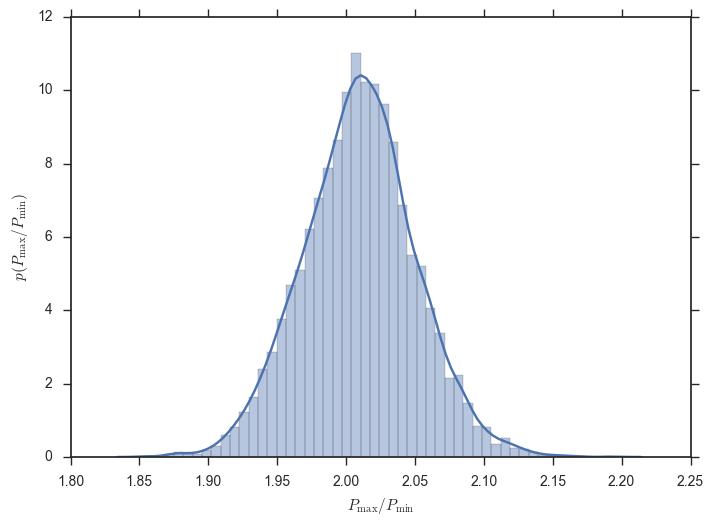

PyObject <matplotlib.text.Text object at 0x32a3ad290>

In [21]:
seaborn.distplot(Pmax0./Pmin0)
xlabel(L"$P_\mathrm{max}/P_\mathrm{min}$")
ylabel(L"$p\left(P_\mathrm{max}/P_\mathrm{min}\right)$")

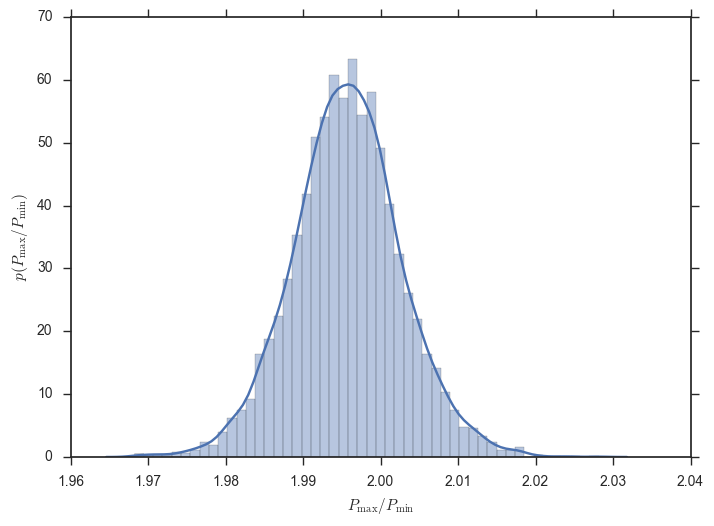

PyObject <matplotlib.text.Text object at 0x32a761110>

In [22]:
seaborn.distplot(Pmax9./Pmin9)
xlabel(L"$P_\mathrm{max}/P_\mathrm{min}$")
ylabel(L"$p\left(P_\mathrm{max}/P_\mathrm{min}\right)$")

In both systems we seem to have found the first and second harmonics of a signal....

## Decay Rate (Coherence Timescale)

In [23]:
drates0 = Kalman.drates(post0, ps0)
drates9 = Kalman.drates(post9, ps9)

5x6382 Array{Float64,2}:
 -0.014561  -0.0153399  -0.0207278  …  -0.0143985  -0.01426    -0.0145598
 -0.014561  -0.0153399  -0.0207278     -0.0143985  -0.01426    -0.0145598
 -0.024185  -0.015748   -0.0359993     -0.0147712  -0.0143506  -0.0165783
 -0.024185  -0.015748   -0.0359993     -0.0147712  -0.0143506  -0.0165783
 -6.81837   -4.47128    -8.49492       -5.41228    -6.46041    -6.58319  

In [24]:
drate_fund0 = zeros(size(drates0,2))
drate_fund9 = zeros(size(drates9,2))
drate_harm0 = zeros(size(drates0,2))
drate_harm9 = zeros(size(drates9,2))
for i in 1:size(drates0, 2)
    inds = sortperm(freqs0[:,i])
    drate_fund0[i] = drates0[inds[end-1],i] # Smallest (positive) freq decay rate
    drate_harm0[i] = drates0[inds[end],i] # Largest freq decay rate
end
for i in 1:size(drates9, 2)
    inds = sortperm(freqs9[:,i])
    drate_fund9[i] = drates9[inds[end-1],i]
    drate_harm9[i] = drates9[inds[end],i]
end

Timescales assocaited with the fundamental and harmonic mode for EPIC 211000411.  The prior on the timescale extends only out to $T_\mathrm{obs}$, so the really sharp (i.e. long-timescale) modes have a cutoff due to the prior.

You can see that the timescale for the fundamental mode is permitted to be quite short---i.e. that the mode is evolving, as is evident in the lightcurve.

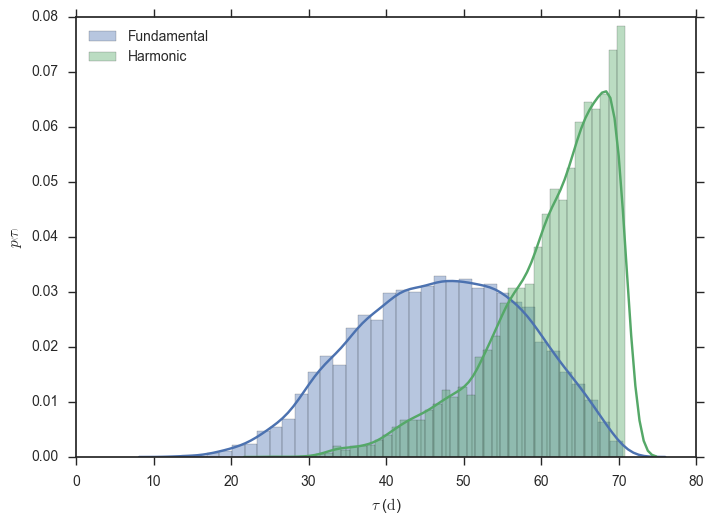

PyObject <matplotlib.legend.Legend object at 0x3280c25d0>

In [25]:
seaborn.distplot(-1.0./drate_fund0, label="Fundamental")
seaborn.distplot(-1.0./drate_harm0, label="Harmonic")
xlabel(L"$\tau$ ($\mathrm{d}$)")
ylabel(L"$p\left(\tau\right)$")
legend(loc="upper left")

Timescales associated with the fundamential and harmonic mode of EPIC 211098454

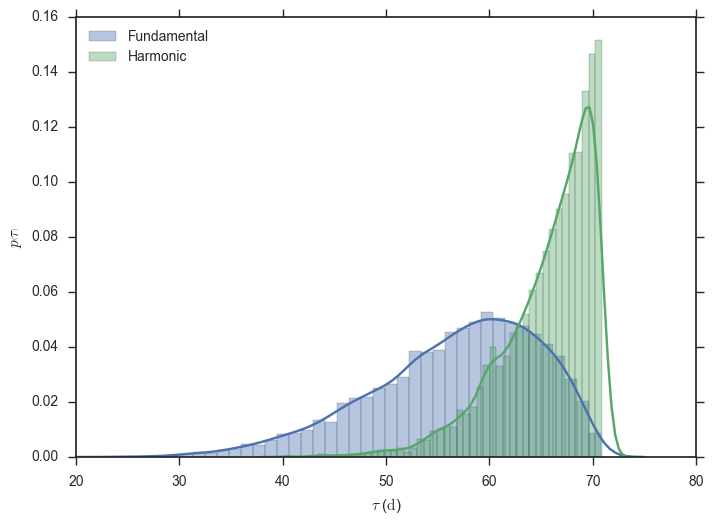

PyObject <matplotlib.legend.Legend object at 0x328187c10>

In [27]:
seaborn.distplot(-1.0./drate_fund9, label="Fundamental")
seaborn.distplot(-1.0./drate_harm9, label="Harmonic")
xlabel(L"$\tau$ ($\mathrm{d}$)")
ylabel(L"$p\left(\tau\right)$")
legend(loc="upper left")

## Amplitude Ratios

TODO: Amplitude ratios!

## What about $(7,6)$ Models

These models allow for three modes.

In [28]:
ns976 = open(deserialize, "epic211098454-CARMA/state-7-6.dat", "r")
ns076 = open(deserialize, "epic211000411-CARMA/state-7-6.dat", "r")
ps076 = EnsembleNest.postsample(ns076)
ps976 = EnsembleNest.postsample(ns976)
post076 = Kalman.CARMAKalmanPosterior(lc0[:,1], lc0[:,2], lc0[:,3], 7, 6)
post976 = Kalman.CARMAKalmanPosterior(lc9[:,1], lc9[:,2], lc9[:,3], 7, 6)
nps076 = size(ps076, 2)
nps976 = size(ps976, 2)

7761

In [29]:
psds076 = Kalman.psd(post076, ps076[:, rand(1:nps076, 1000)], fs0)
psds976 = Kalman.psd(post976, ps976[:, rand(1:nps976, 1000)], fs9)

1734x1000 Array{Float64,2}:
 7629.5       3127.29      4246.5       …  3757.93      3823.29    
 1419.39       584.485      556.174         847.801      550.84    
  647.104      321.357      272.307         480.976      291.7     
  405.742      243.965      201.468         365.301      224.669   
  299.349      210.753      173.53          314.251      197.938   
  243.18       193.463      159.53      …   287.453      184.774   
  210.074      183.359      151.391         271.888      177.523   
  189.102      177.003      146.143         262.307      173.321   
  175.171      172.816      142.484         256.268      170.902   
  165.648      169.995      139.771         252.519      169.645   
  159.069      168.099      137.656     …   250.378      169.222   
  154.574      166.879      135.942         249.463      169.462   
  151.644      166.191      134.512         249.565      170.28    
    ⋮                                   ⋱                          
    0.388582     0.3

Below in the $(7,6)$ estimate of the PSD; you can see that there is no evidence for another mode in the data, though there seems to be more low-frequency power than appeared in the $(5,4)$ fit.  There is probably low-frequency fluctuations (maybe associated to imperfect systematic removal?) present in the data at lower power than the modes; the $(5,4)$ model is essentially tapped out after accounting for the two modes (4 out of 5 AR parameters) and the falloff at high frequency (the remaining AR parameter).

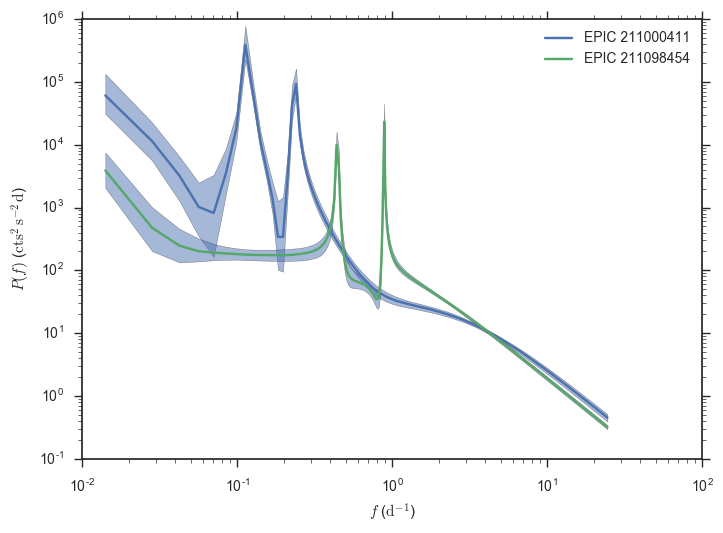

PyObject <matplotlib.legend.Legend object at 0x325ceafd0>

In [30]:
plot_psd(fs0, psds076)
plot_psd(fs9, psds976)
legend([name0, name9], loc="upper right")